In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
def generate_output_from_model(model, tokenizer, prompt, max_new_tokens=50):

  inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation = True)
  inputs = {k: v.to(model.device) for k, v in inputs.items()}
  outputs = model.generate(
      **inputs,
      max_new_tokens = max_new_tokens,
      pad_token_id = tokenizer.pad_token_id,
      do_sample=True,
      temperature=0.7,
      top_p=0.9
      )

  decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
  generated_ids = outputs[0][inputs.input_ids.shape[1]:]
  return decoded_text, generated_ids

In [ ]:
from transformers import pipeline

politeness_classifier = pipeline(
    "text-classification",
    model = "Intel/polite-guard",
    top_k=4,
    device = 0 if torch.cuda.is_available() else -1
)

def get_reward(generated_text):
    results = politeness_classifier(generated_text, truncation=True)[0]
    label_to_value = {
        'impolite': -1.0,
        'neutral': 0.0,
        'somewhat polite': 0.5,
        'polite': 1.0
    }

    # Calculate a weighted average of the scores
    total_reward = 0.0
    for result in results:
        label = result['label']
        score = result['score']
        value = label_to_value.get(label, 0.0)
        total_reward += value * score

    return total_reward

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
from torch.nn.functional import log_softmax

def compute_log_probabilities(model, input_ids, output_ids):
    full_sequence_ids = torch.cat([input_ids, output_ids], dim=-1)
    logits = model(full_sequence_ids).logits
    log_probs = log_softmax(logits, dim=-1)
    generated_log_probs_logits = log_probs[:, input_ids.shape[1]-1:-1, :]
    selected_log_probs = generated_log_probs_logits.gather(2, output_ids.unsqueeze(-1)).squeeze(-1)
    return selected_log_probs

In [ ]:
def ppo_loss(old_logprobs, new_logprobs, advantages, epsilon = 0.1 ):
  ratio = torch.exp(new_logprobs - old_logprobs)
  unclipped = ratio * advantages
  clipped = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantages
  return -torch.min(unclipped, clipped).mean()

In [ ]:
import itertools
import random

def generate_prompts(num_prompts):

    # A wide variety of polite and neutral starters
    polite_starters = [
        "Could you please tell me about",
        "I would be grateful if you could provide information on",
        "Would you mind explaining",
        "I was hoping you could tell me about",
        "If you have the time, please elaborate on",
        "I would appreciate it if you could share some details on",
        "I am writing to respectfully request details about",
        "Would it be possible to get more information on",
        "I am interested in learning more about",
        "Kindly provide some insights into",
    ]

    # A diverse range of topics
    topics = [
        "the history of the Roman Empire",
        "the process of photosynthesis",
        "how to change a flat tire",
        "the main principles of quantum mechanics",
        "the impact of climate change on ocean levels",
        "the life cycle of a butterfly",
        "the benefits of regular exercise",
        "the capital cities of Australia",
        "how to bake a sourdough bread",
        "the causes of the Great Depression",
        "the role of artificial intelligence in healthcare",
        "different types of renewable energy sources",
        "the plot of Shakespeare's 'Hamlet'",
        "the latest developments in space exploration",
        "the function of the human nervous system",
        "the history of the internet",
        "how to write a good email",
        "the main features of the Python programming language",
        "the geography of the Amazon rainforest",
        "the principles of sustainable farming",
        "the process of brewing beer",
        "how to learn a new language effectively",
        "the differences between a republic and a democracy",
        "the history of ancient Greece",
        "the basics of investing in the stock market",
        "the art of public speaking",
        "the process of DNA replication",
        "the life of Leonardo da Vinci",
        "the stages of a volcanic eruption",
        "the principles of classical music composition",
    ]

    # Create all possible combinations of starters and topics
    all_combinations = list(itertools.product(polite_starters, topics))

    # Shuffle the combinations for randomness
    random.shuffle(all_combinations)

    # Generate the requested number of prompts
    prompts = [f"{starter} {topic}." for starter, topic in all_combinations[:num_prompts]]

    # Add a few raw, neutral prompts for robustness
    neutral_starters = [
        "What is",
        "Tell me about",
        "Explain the process of",
        "How do I",
        "Give me information on"
    ]

    for i in range(min(num_prompts, 50)): # Add up to 50 raw prompts
        starter = random.choice(neutral_starters)
        topic = random.choice(topics)
        prompts.append(f"{starter} {topic}.")

    random.shuffle(prompts)

    return prompts

In [ ]:
# Hyperparams
num_epochs = 20
learning_rate = 1e-6
epsilon = 0.2
max_new_tokens = 20
NUM_PROMPTS_TO_GENERATE = 1000

In [ ]:

from copy import deepcopy



old_model = deepcopy(model)
old_model.eval()


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Starting PPO Training....")
loss_values = []
reward_values = []

prompts = generate_prompts(NUM_PROMPTS_TO_GENERATE)

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

    # Create and move old_model to the GPU for this epoch's reference
    old_model = deepcopy(model)
    old_model.eval()
    old_model.to(device)

    for prompt in prompts:

        generated_text, generated_ids = generate_output_from_model(model, tokenizer, prompt, max_new_tokens=50)

        reward = get_reward(generated_text)

        inputs = tokenizer(prompt, return_tensors='pt').to(device)


        generated_ids_2d = generated_ids.unsqueeze(0).to(device)

        with torch.no_grad():
          old_logprobs = compute_log_probabilities(old_model, inputs['input_ids'], generated_ids_2d).sum()

        new_logprobs = compute_log_probabilities(model, inputs['input_ids'], generated_ids_2d).sum()


        advantages = torch.tensor([reward], dtype=torch.float32).to(device)

        loss = ppo_loss(old_logprobs, new_logprobs, advantages, epsilon)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_values.append(loss.item())
        reward_values.append(reward)

print("\nPPO training complete.")

Using device: cuda
Starting PPO Training....

--- Epoch 1/20 ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.



--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---

PPO training complete.


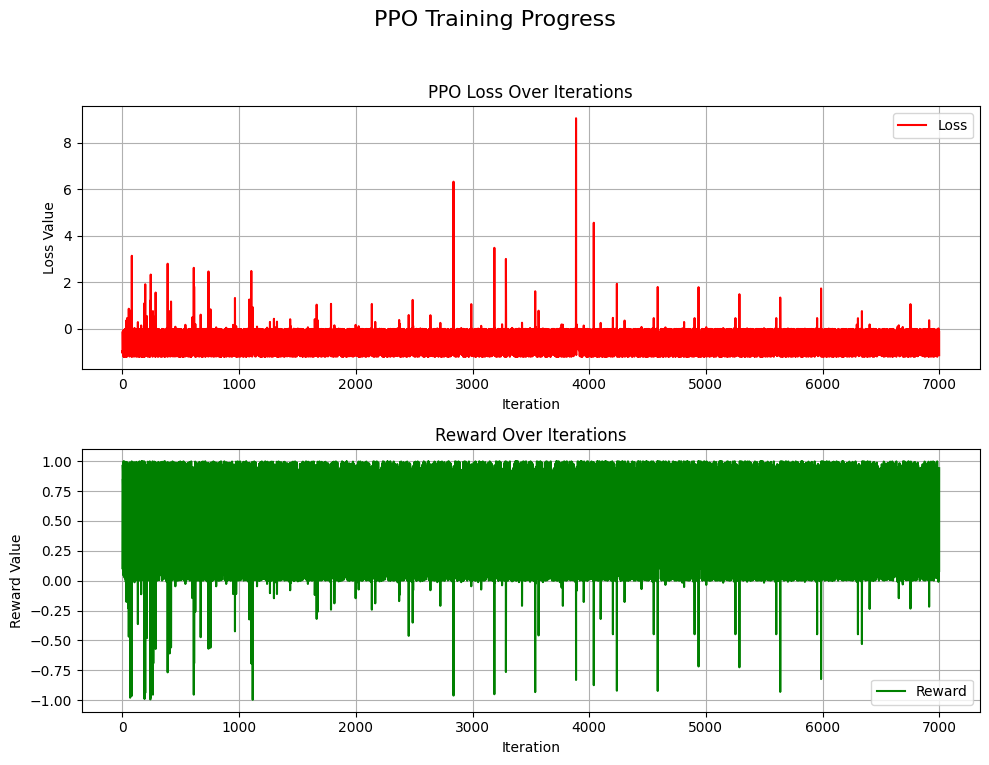

In [ ]:
import matplotlib.pyplot as plt
# --- 5. Plotting the Results ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('PPO Training Progress', fontsize=16)

ax1.plot(loss_values, label='Loss', color='red')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss Value')
ax1.set_title('PPO Loss Over Iterations')
ax1.grid(True)
ax1.legend()

ax2.plot(reward_values, label='Reward', color='green')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Reward Value')
ax2.set_title('Reward Over Iterations')
ax2.grid(True)
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('ppo_training_progress.png')


In [ ]:
def test_model(model, old_model, tokenizer, test_prompts, max_new_tokens=20):
    """
    Compares the output of the fine-tuned model with the base model.
    """
    print("\n" + "="*50)
    print("=             Testing the Model             =")
    print("="*50)

    for prompt in test_prompts:
        print(f"\n--- Prompt: {prompt} ---")


        base_output, _ = generate_output_from_model(old_model, tokenizer, prompt, max_new_tokens)
        print(f"Base Model Output: {base_output}")


        fine_tuned_output, _ = generate_output_from_model(model, tokenizer, prompt, max_new_tokens)
        print(f"Fine-Tuned Model Output: {fine_tuned_output}")

        base_reward = get_reward(base_output)
        fine_tuned_reward = get_reward(fine_tuned_output)
        print(f"Base Reward: {base_reward}, Fine-tuned Reward: {fine_tuned_reward}")

        # PRINT DIFFERENCE IN REWARDS
        print(f"Difference in Reward: {base_reward - fine_tuned_reward}")

test_prompts = [
    "I would be grateful if you could",
    "Please provide some information about",
    "Could you kindly explain",
    "I was hoping you could tell me about",
    "If you wouldn't mind, could you tell me",

]


test_model(model, old_model, tokenizer, test_prompts, max_new_tokens)



=             Testing the Model             =

--- Prompt: I would be grateful if you could ---
Base Model Output: I would be grateful if you could share your thoughts on the subject.

I am a former student of the University of California,
Fine-Tuned Model Output: I would be grateful if you could give me a few pointers on how to use the "I" in the "I" in the
Base Reward: 0.8884647328522988, Fine-tuned Reward: 0.6555994710652158
Difference in Reward: 0.232865261787083

--- Prompt: Please provide some information about ---
Base Model Output: Please provide some information about yourself.

You are a registered user of the Etsy shop, and have read and agreed to
Fine-Tuned Model Output: Please provide some information about yourself.

You are a registered user of the Etsy shop Etsy.com and have taken the
Base Reward: 0.001445322370273061, Fine-tuned Reward: 0.0004746846097987145
Difference in Reward: 0.0009706377604743466

--- Prompt: Could you kindly explain ---
Base Model Output: Could 